<a href="https://colab.research.google.com/github/MarkVoitov/artificial_intelligence_course/blob/main/digital_depot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Описание тех. процесса**

Локомотив заходит в депо на осмотр колес примерно 1 раз в месяц. При каждом заходе локомотива в депо на ремонт мастера снимают геометрические параметры колесных пар. На основании проведенных замеров принимается решение о том, безопасно ли дальше эксплуатировать колесо, или нужно провести ремонт (обточить колесо или поменять его).

На рисунке изображены основные геометрические параметры колеса, которые проверяются в депо.

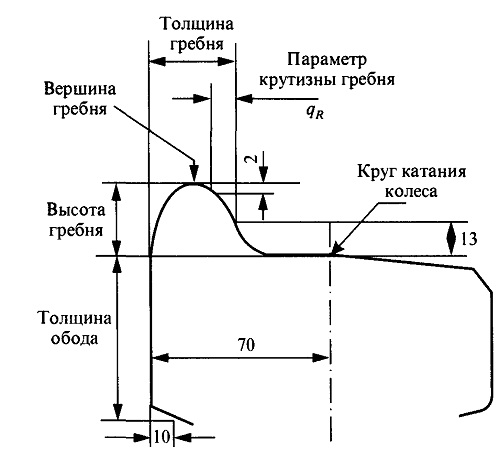

Параметры износа колеса среди прочего зависят от геометрии колеса. В качестве учебной модели необходимо предсказать значение толщины гребня на 10 дней в будущее на основании данных о геометрии колеса с предыдущего замера.

Данные находятся в файлах:

1) measurements.csv - исходные данные для обучения и тестирования модели. Каждая строчка представляет собой 1 замер параметров одного колеса.

• wheel_id - уникальный идентификатор замера;

• date - дата текущего замера;

• flange_height – высота гребня;

• flange_width - толщина гребня;

• qr - крутизна гребня;

• tread_wear - прокат;

• rim_thickness - толщина бандажа;

• wheel_diameter - диаметр;

2) features_test.csv – выборка для решения кейса. Также содержит замеры колес как в исходных данных. Необходимо на основе данных замеров предсказать параметр «толщина гребня» этих колес на дату через 10 дней после замера (содержат предыдущие замеры с приставкой “previous_”, например, previous_flange_width).

***1. Подготовка данных***

*1. Откройте данные и изучите их.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab_notebooks/artificial_intelligence_course/02_digital_depot/measurements.csv')
df

,wheel_id,flange_height,flange_width,qr,tread_wear,rim_thickness,wheel_diameter,date
0,1331,32.27,30.08,10.52,2.27,75.25,1220.50,61
1,8608,31.34,31.71,10.42,1.34,57.23,1184.46,61
2,8609,31.30,30.85,8.36,1.30,56.35,1182.70,61
3,8612,31.24,28.07,8.74,1.24,73.01,1216.03,61
4,8613,30.42,29.37,10.13,0.42,72.05,1214.11,61
...,...,...,...,...,...,...,...,...
32807,9753,30.11,30.67,7.47,0.11,92.02,1251.00,212
32808,9749,30.66,30.73,8.35,0.66,93.00,1255.00,212
32809,9748,30.59,30.95,8.76,0.59,92.46,1254.00,212
32810,9746,30.85,31.98,9.91,0.85,92.16,1254.00,212


In [3]:
# размерность датасета (n_samples, n_features)
df.shape

(32812, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32812 entries, 0 to 32811
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wheel_id        32812 non-null  int64  
 1   flange_height   32812 non-null  float64
 2   flange_width    32812 non-null  float64
 3   qr              32812 non-null  float64
 4   tread_wear      32812 non-null  float64
 5   rim_thickness   32812 non-null  float64
 6   wheel_diameter  32812 non-null  float64
 7   date            32812 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 2.0 MB


In [5]:
# описательная статистика количественных признаков
df.describe()

,wheel_id,flange_height,flange_width,qr,tread_wear,rim_thickness,wheel_diameter,date
count,32812.000000,32812.000000,32812.000000,32812.000000,32812.000000,32812.000000,3.281200e+04,32812.000000
mean,6357.836158,32.216903,29.307854,9.252663,2.148423,81.063637,1.366525e+03,146.497714
std,3820.649237,2.595155,1.744670,2.150288,2.468641,12.477192,6.669433e+04,32.713383
min,0.000000,-1.190000,-2.160000,-296.740000,-31.920000,-278.560000,0.000000e+00,61.000000
25%,3010.750000,30.870000,28.100000,8.480000,0.800000,74.997500,1.195105e+03,125.000000
50%,6247.500000,32.300000,29.310000,9.230000,2.050000,84.860000,1.229100e+03,144.000000
75%,9004.250000,33.430000,30.520000,9.990000,3.250000,88.992500,1.242260e+03,172.000000
max,14575.000000,334.220000,60.750000,88.510000,302.230000,293.120000,1.208121e+07,212.000000


*2. Выстроите цепочку замеров по одним и тем же колесам. Для каждого текущего замера найдите предыдущий замер этого же колеса и его параметры (важно - предыдущие замеры необходимо добавить в соответствующие столбцы с приставкой “previous_”).*

Отсортируем датасет сначала по wheel_id, затем по date. Таким образом выстроим цепочку замеров по одним и тем же колёсам по датам.

In [6]:
df = df.sort_values(by=['wheel_id', 'date']).reset_index(drop=True)

В начале удалим строки - полные дубликаты.

Также удалим строки, которые присутствуют в датасете только один раз, у них нет предыдущего замера.



In [7]:
df = df.drop_duplicates(ignore_index=True)

In [8]:
wheel_id_without_previous = df[df['wheel_id'].isin(df['wheel_id'].value_counts()[df['wheel_id'].value_counts()==1].index)].wheel_id
len(wheel_id_without_previous)

9804

In [9]:
df = df[~df['wheel_id'].isin(wheel_id_without_previous)].reset_index(drop=True)

Добавим новые столбцы, а также столбец date_diff - количество дней между замерами в цепочках.

In [10]:
df[['previous_flange_height', 'previous_flange_width', 'previous_qr', 'previous_tread_wear', 'previous_rim_thickness', 'previous_wheel_diameter', 'date_diff']] = np.nan

try:
  for i in range(len(df)):
    if df['wheel_id'][i] == df['wheel_id'][i+1]:
      df['previous_flange_height'][i+1] = df['flange_height'][i]
      df['previous_flange_width'][i+1] = df['flange_width'][i]
      df['previous_qr'][i+1] = df['qr'][i]
      df['previous_tread_wear'][i+1] = df['tread_wear'][i]
      df['previous_rim_thickness'][i+1] = df['rim_thickness'][i]
      df['previous_wheel_diameter'][i+1] = df['wheel_diameter'][i]
      df['date_diff'][i+1] = df['date'][i+1] - df['date'][i]
except KeyError:
  pass

df = df.reindex(columns=[
    'wheel_id', 'date', 'date_diff', 'previous_flange_height', 'flange_height', 'previous_flange_width', 'flange_width', 'previous_qr', 'qr', 'previous_tread_wear', 'tread_wear',
    'previous_rim_thickness', 'rim_thickness', 'previous_wheel_diameter', 'wheel_diameter'])

df

,wheel_id,date,date_diff,previous_flange_height,flange_height,previous_flange_width,flange_width,previous_qr,qr,previous_tread_wear,tread_wear,previous_rim_thickness,rim_thickness,previous_wheel_diameter,wheel_diameter
0,288,151,NaN,NaN,30.34,NaN,28.07,NaN,6.91,NaN,0.34,NaN,84.30,NaN,1234.00
1,288,151,0.0,30.34,30.34,28.07,28.07,6.91,6.91,0.34,0.34,84.30,84.30,1234.00,1230.00
2,289,151,NaN,NaN,30.53,NaN,26.96,NaN,7.20,NaN,0.53,NaN,86.05,NaN,1235.00
3,289,151,0.0,30.53,30.53,26.96,26.96,7.20,7.20,0.53,0.53,86.05,86.05,1235.00,1232.00
4,290,151,NaN,NaN,30.32,NaN,28.47,NaN,7.42,NaN,0.32,NaN,88.52,NaN,1227.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18341,14562,121,2.0,34.03,33.85,31.63,31.91,10.35,10.60,2.04,1.86,60.90,60.96,1191.79,1191.93
18342,14562,170,49.0,33.85,34.11,31.91,31.33,10.60,9.79,1.86,2.12,60.96,60.06,1191.93,1186.00
18343,14563,119,NaN,NaN,34.73,NaN,30.51,NaN,9.81,NaN,2.74,NaN,62.08,NaN,1194.16
18344,14563,121,2.0,34.73,33.08,30.51,31.17,9.81,9.56,2.74,1.09,62.08,60.32,1194.16,1190.63


*3. Проведите предобработку данных (уберите пустые значения в датафрейме у которых нет предыдущего замера)*

In [11]:
df = df.dropna().reset_index(drop=True)
df['date_diff'] = df['date_diff'].astype('int')

df

,wheel_id,date,date_diff,previous_flange_height,flange_height,previous_flange_width,flange_width,previous_qr,qr,previous_tread_wear,tread_wear,previous_rim_thickness,rim_thickness,previous_wheel_diameter,wheel_diameter
0,288,151,0,30.34,30.34,28.07,28.07,6.91,6.91,0.34,0.34,84.30,84.30,1234.00,1230.00
1,289,151,0,30.53,30.53,26.96,26.96,7.20,7.20,0.53,0.53,86.05,86.05,1235.00,1232.00
2,290,151,0,30.32,30.32,28.47,28.47,7.42,7.42,0.32,0.32,88.52,88.52,1227.00,1236.00
3,291,151,0,29.75,29.75,27.07,27.07,6.53,6.53,-0.25,-0.25,88.09,88.09,1228.00,1236.00
4,292,151,0,30.32,30.32,27.35,27.35,7.27,7.27,0.32,0.32,91.38,91.38,1240.00,1238.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,14561,170,51,35.11,33.11,29.21,28.08,10.53,8.69,3.12,1.12,59.99,57.31,1189.98,1181.00
13570,14562,121,2,34.03,33.85,31.63,31.91,10.35,10.60,2.04,1.86,60.90,60.96,1191.79,1191.93
13571,14562,170,49,33.85,34.11,31.91,31.33,10.60,9.79,1.86,2.12,60.96,60.06,1191.93,1186.00
13572,14563,121,2,34.73,33.08,30.51,31.17,9.81,9.56,2.74,1.09,62.08,60.32,1194.16,1190.63


***2. Проанализируйте данные***

*1. В ходе нормального износа локомотивного колеса проходит стачивание металла и, исходя из этого, толщина гребня не может увеличиваться между замерами, поэтому отфильтруйте и оставьте только те замеры, где толщина гребня меньше предыдущей (для цели кейса по остальным параметрам можно не проводить фильтрацию). Фундаментальная причины, почему в данных встречается что, толщина гребня растет – обточки колес, погрешности измерений, незадокументированные перекатки колес локотива.*

In [12]:
df = df[(df['flange_width'] < df['previous_flange_width']) & (df['flange_width'] > 0)].reset_index(drop=True)

*2. Рассчитайте количество дней между замерами в цепочках, оставьте только те замеры, входящие в диапазон от 10 до 50 дней (в среднем локомотив заходит в депо 1 раз в месяц).*

*1) Если между замерами прошло 10 дней и меньше, то высока доли погрешности измерений в депо*

*2) Если между замерами прошло 50 дней и больше, то, вероятно, в исходных данных был пропущен промежуточный замер*

Используем ранее рассчитанный столбец date_diff. Заполнение этого столбца значениями на более раннем этапе позволяет сейчас оставить больше данных для последующего моделирования.

In [13]:
df = df[(df['date_diff'] > 10) & (df['date_diff'] < 50)].reset_index(drop=True)

*3. Посчитайте изменение толщины гребня за 1 день, рассчитайте каким будет значение толщины гребня через 10 дней - это и будет нашим целевым показателем.*

In [14]:
df['following_flange_width'] = round(df['flange_width'] - ((df['previous_flange_width'] - df['flange_width']) / df['date_diff'] * 10), 2)
df

,wheel_id,date,date_diff,previous_flange_height,flange_height,previous_flange_width,flange_width,previous_qr,qr,previous_tread_wear,tread_wear,previous_rim_thickness,rim_thickness,previous_wheel_diameter,wheel_diameter,following_flange_width
0,961,110,38,36.24,32.25,30.87,29.60,11.88,9.92,4.25,2.25,77.60,49.38,1225.21,1168.75,29.27
1,964,110,38,35.70,31.82,32.19,29.19,11.26,11.17,3.71,1.82,71.24,50.02,1212.48,1170.03,28.40
2,965,110,38,35.54,31.98,32.23,29.38,11.70,11.02,3.55,1.98,70.04,49.41,1210.08,1168.81,28.63
3,969,110,38,34.92,30.45,30.57,28.92,11.03,9.67,2.93,0.45,77.37,52.73,1224.74,1175.47,28.49
4,972,110,38,35.56,32.11,30.64,29.31,11.49,11.58,3.57,2.11,0.00,55.03,0.00,1180.06,28.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5336,14555,170,49,33.61,34.10,32.79,31.95,9.96,9.38,1.62,2.11,62.89,63.45,1195.78,1193.00,31.78
5337,14556,170,49,33.92,34.51,30.04,28.70,9.74,10.31,1.93,2.52,61.47,61.41,1192.93,1186.00,28.43
5338,14557,170,49,32.93,33.40,32.26,30.70,10.51,9.44,0.94,1.41,61.52,59.52,1193.04,1183.60,30.38
5339,14562,170,49,33.85,34.11,31.91,31.33,10.60,9.79,1.86,2.12,60.96,60.06,1191.93,1186.00,31.21


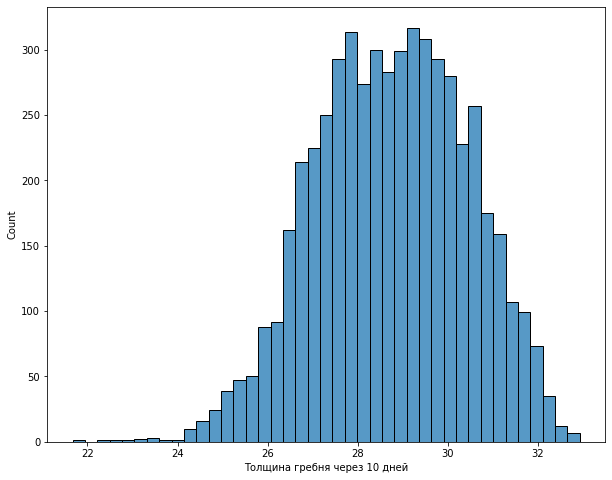

In [15]:
# посмотрим распределение таргета
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='following_flange_width')
plt.xlabel('Толщина гребня через 10 дней')
plt.show()

**4. Постройте модель**

*1. Разбейте выборку на обучающую и валидационную.*

In [16]:
# удалим столбцы с датами и айди колёс
df = df.drop(['wheel_id', 'date'], axis=1)
df.head()

,date_diff,previous_flange_height,flange_height,previous_flange_width,flange_width,previous_qr,qr,previous_tread_wear,tread_wear,previous_rim_thickness,rim_thickness,previous_wheel_diameter,wheel_diameter,following_flange_width
0,38,36.24,32.25,30.87,29.60,11.88,9.92,4.25,2.25,77.60,49.38,1225.21,1168.75,29.27
1,38,35.70,31.82,32.19,29.19,11.26,11.17,3.71,1.82,71.24,50.02,1212.48,1170.03,28.40
2,38,35.54,31.98,32.23,29.38,11.70,11.02,3.55,1.98,70.04,49.41,1210.08,1168.81,28.63
3,38,34.92,30.45,30.57,28.92,11.03,9.67,2.93,0.45,77.37,52.73,1224.74,1175.47,28.49
4,38,35.56,32.11,30.64,29.31,11.49,11.58,3.57,2.11,0.00,55.03,0.00,1180.06,28.96


In [17]:
X_train, x_valid, y_train, y_valid = train_test_split(df.iloc[:, :-1], df['following_flange_width'], train_size=0.75)

*2. Обучите различные модели (не менее 2) и оцените. Если потребуется, подберите лучшие гиперпараметры на валидационной выборке.*

1. Linear regression / Polynomial features / Ridge / Lasso

In [18]:
# простая линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_lr, y_valid), 2))
print('R2:', round(r2_score(pred_lr, y_valid), 2))

MAE: 0.06
R2: 1.0


In [19]:
# LinearRegression + PolynomialFeatures(2)
poly = PolynomialFeatures()
X_train_transformed = poly.fit_transform(X_train)
x_valid_transformed = poly.fit_transform(x_valid)

lr_transformed = LinearRegression()
lr_transformed.fit(X_train_transformed, y_train)
pred_lr_transformed = lr_transformed.predict(x_valid_transformed)
print('MAE:', round(mean_absolute_error(pred_lr_transformed, y_valid), 2))
print('R2:', round(r2_score(pred_lr_transformed, y_valid), 2))

MAE: 0.03
R2: 1.0


In [20]:
# Ridge grid search
ridge = Ridge()
params_grid_ridge = {'alpha': [0.1, 0.5, 0.9]}

grid_ridge = GridSearchCV(ridge,
                          params_grid_ridge,
                          cv=KFold(shuffle=True, random_state=0),
                          scoring='neg_mean_absolute_percentage_error')
grid_ridge.fit(X_train, y_train)
print('Best params:', grid_ridge.best_params_)

ridge = Ridge(alpha=grid_ridge.best_params_['alpha'])
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_ridge, y_valid), 2))
print('R2:', round(r2_score(pred_ridge, y_valid), 2))

Best params: {'alpha': 0.9}
MAE: 0.06
R2: 1.0


In [21]:
# Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_lasso, y_valid), 2))
print('R2:', round(r2_score(pred_lasso, y_valid), 2))

MAE: 0.56
R2: 0.53


2. Random forest

In [22]:
params_grid_rf = {'max_depth': np.arange(1, 6),
                  'n_estimators': [200, 500, 1000]
                  }

grid_rf = GridSearchCV(RandomForestRegressor(),
                       params_grid_rf,
                       cv=KFold(shuffle=True, random_state=0),
                       scoring='neg_mean_absolute_percentage_error'
                       )
grid_rf.fit(X_train, y_train)
print('Best params:', grid_rf.best_params_)

rf = RandomForestRegressor(max_depth=grid_rf.best_params_['max_depth'],
                           n_estimators=grid_rf.best_params_['n_estimators']
                           )
rf.fit(X_train, y_train)
pred_rf = rf.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_rf, y_valid), 2))
print('R2:', round(r2_score(pred_rf, y_valid), 2))

Best params: {'max_depth': 5, 'n_estimators': 500}
MAE: 0.14
R2: 0.99


3. XGBoost

In [23]:
params_grid_xgb = {'max_depth': np.arange(1, 6),
                   'n_estimators': [200, 500, 1000]
                   }

grid_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror'),
                        params_grid_xgb,
                        cv=KFold(shuffle=True, random_state=0),
                        scoring='neg_mean_absolute_percentage_error')
grid_xgb.fit(X_train, y_train)
print('Best params:', grid_xgb.best_params_)

xgb = XGBRegressor(max_depth=grid_xgb.best_params_['max_depth'],
                   n_estimators=grid_xgb.best_params_['n_estimators']
                   )
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_xgb, y_valid), 2))
print('R2:', round(r2_score(pred_xgb, y_valid), 2))

Best params: {'max_depth': 4, 'n_estimators': 1000}
[11:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.03
R2: 1.0


4. CatBoost

In [24]:
params_grid_cb = {'depth': np.arange(1, 6),
                   'iterations' : [200, 500, 1000]
                   }

grid_cb = GridSearchCV(CatBoostRegressor(),
                        params_grid_cb,
                        cv=KFold(shuffle=True, random_state=0),
                        scoring='neg_mean_absolute_percentage_error'
                        )
grid_cb.fit(X_train, y_train, verbose=False)
print('Best params:', grid_cb.best_params_)

cb = CatBoostRegressor(depth=grid_cb.best_params_['depth'],
                        iterations=grid_cb.best_params_['iterations']
                        )
cb.fit(X_train, y_train, verbose=50, plot=True)
pred_cb = cb.predict(x_valid)
print('MAE:', round(mean_absolute_error(pred_cb, y_valid), 2))
print('R2:', round(r2_score(pred_cb, y_valid), 2))

Best params: {'depth': 5, 'iterations': 1000}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050979
0:	learn: 1.6006868	total: 2.72ms	remaining: 2.72s
50:	learn: 0.2969453	total: 138ms	remaining: 2.57s
100:	learn: 0.1715066	total: 274ms	remaining: 2.44s
150:	learn: 0.1325779	total: 406ms	remaining: 2.28s
200:	learn: 0.1069167	total: 532ms	remaining: 2.12s
250:	learn: 0.0897536	total: 664ms	remaining: 1.98s
300:	learn: 0.0760757	total: 822ms	remaining: 1.91s
350:	learn: 0.0686507	total: 985ms	remaining: 1.82s
400:	learn: 0.0617886	total: 1.12s	remaining: 1.67s
450:	learn: 0.0564161	total: 1.25s	remaining: 1.52s
500:	learn: 0.0522644	total: 1.38s	remaining: 1.38s
550:	learn: 0.0486560	total: 1.52s	remaining: 1.24s
600:	learn: 0.0453457	total: 1.66s	remaining: 1.1s
650:	learn: 0.0427935	total: 1.79s	remaining: 958ms
700:	learn: 0.0405052	total: 1.93s	remaining: 821ms
750:	learn: 0.0385573	total: 2.11s	remaining: 699ms
800:	learn: 0.0367868	total: 2.25s	remaining: 559ms
850:	learn: 0.0352206	total: 2.38s	remaining: 417ms
900:	learn: 0.0338066	total: 2.53s	re

3. Рассчитайте r2 и абсолютную ошибку для каждой модели, выберите модель с наименьшей ошибкой.

In [25]:
metrics_df = pd.DataFrame(
    columns=[
        'LR',
        'LR + PolyFeatures',
        'Ridge',
        'Lasso',
        'Random forest',
        'XGBoost',
        'CatBoost'],
    index=['MAE', 'R2']
)

metrics_df.loc['MAE'] = [
    round(mean_absolute_error(pred_lr, y_valid), 2),
    round(mean_absolute_error(pred_lr_transformed, y_valid), 2),
    round(mean_absolute_error(pred_ridge, y_valid), 2),
    round(mean_absolute_error(pred_lasso, y_valid), 2),
    round(mean_absolute_error(pred_rf, y_valid), 2),
    round(mean_absolute_error(pred_xgb, y_valid), 2),
    round(mean_absolute_error(pred_cb, y_valid), 2)
]

metrics_df.loc['R2'] = [
    round(r2_score(pred_lr, y_valid), 2),
    round(r2_score(pred_lr_transformed, y_valid), 2),
    round(r2_score(pred_ridge, y_valid), 2),
    round(r2_score(pred_lasso, y_valid), 2),
    round(r2_score(pred_rf, y_valid), 2),
    round(r2_score(pred_xgb, y_valid), 2),
    round(r2_score(pred_cb, y_valid), 2)
]

metrics_df

,LR,LR + PolyFeatures,Ridge,Lasso,Random forest,XGBoost,CatBoost
MAE,0.06,0.03,0.06,0.56,0.14,0.03,0.04
R2,1.0,1.0,1.0,0.53,0.99,1.0,1.0


Метрика MAE показывает среднюю абсолютную ошибку в единицах измерения таргета (для толщины гребня колеса локомотива это, скорее всего, миллиметры) и для идеальной модели должна стремится к 0.

Метрика R2 (коэффициент детерминации) показывает долю объясняемой моделью дисперсии и для идеальной модели должна стремится к 1.

Почти все использованные алгоритмы, кроме линейной модели Лассо, показали высокие результаты.

Наилучшей моделью является модель градиентного бустинга XGBoost с гиперпараметрами max_depth: 4 и n_estimators: 1000.

*4. Сделайте прогноз (толщины гребня через 10 дней) для колес и замеров, которые находятся в тестовой выборке (features_test.csv).*

In [26]:
x_test = pd.read_csv('/content/drive/MyDrive/Colab_notebooks/artificial_intelligence_course/02_digital_depot/features_test.csv')
x_test

,previous_flange_width,previous_flange_height,previous_rim_thickness,previous_wheel_diameter
0,29.57,31.68,88.73,0.00
1,31.29,34.42,85.96,1241.92
2,30.64,33.60,66.04,1202.08
3,29.46,33.35,0.00,0.00
4,28.68,30.80,69.42,0.00
...,...,...,...,...
663,28.15,32.38,74.39,1218.77
664,28.12,31.21,68.06,1196.00
665,29.22,35.33,87.44,1244.89
666,28.47,30.34,70.60,0.00


По неизвестной причине тестовая выборка "features_test.csv" включает в себя только 4 признака (при обучении и валидации модели было использовано 13):
*   previous_flange_width,
*   previous_flange_height,
*   previous_rim_thickness,
*   previous_wheel_diameter

Таким образом, поскольку для корректной работы модели состав признаков обучающей и валидационной выборки должен совпадать с признаками тестовой выборки, осуществить прогноз для тестовой выборки невозможно.

In [27]:
y_pred = xgb.predict(x_test)

ValueError: ignored

**4. Проверка**

*1. Абсолютная ошибка должна быть менее 0.3.*

In [28]:
print('XGBoost MAE:', round(mean_absolute_error(pred_xgb, y_valid), 2))

XGBoost MAE: 0.03
